In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from LDA import LDA
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score


In [3]:
data_train = np.load('data/fashion_train.npy', mmap_mode='r')
data_test = np.load('data/fashion_test.npy', mmap_mode='r')

In [4]:
X_train = data_train[:, :-1]
y_train = data_train[:, -1]
X_test = data_test[:, :-1]
y_test = data_test[:, -1]

In [6]:
#our LDA
clf = LDA(n_components=4)
clf.fit(X_train, y_train)
lda_transformed_X_train= clf.transform(X_train)
lda_X_test = clf.transform(X_test)

print(lda_X_test.shape, lda_transformed_X_train.shape)

(5000, 4) (10000, 4)


In [11]:
#PCA using sklearn
pca = PCA(n_components=5)
pca_transformed_X_train= pca.fit_transform(X_train, y_train)
pca_X_test_transformed = pca.transform(X_test)

In [53]:
#returns accuracy of KNN classifier
def KNN_accuracy(X_train,y_train,X_test,y_test):
    neigh = KNeighborsClassifier(n_neighbors=3)
    neigh.fit(X_train, y_train)
    predictions = (neigh.predict(X_test))

    acc = np.sum(predictions== y_test)/len(y_test)
    return acc



In [57]:
KNN_accuracy(pca_transformed_X_train,y_train,pca_X_test_transformed,y_test )

0.7516

In [56]:
KNN_accuracy(X_train,y_train, X_test,y_test)

0.823

In [59]:
#KNN_accuracy(pca_transformed_X_train,y_train,pca_X_test_transformed )
KNN_accuracy(lda_transformed_X_train,y_train,lda_X_test,y_test )

0.7956

In [60]:
def cross_val(X,y,n,cv):
    neigh = KNeighborsClassifier(n_neighbors=n)
    neigh.fit(X, y)
    scores = cross_val_score(neigh, X, y, cv=cv)
    return scores

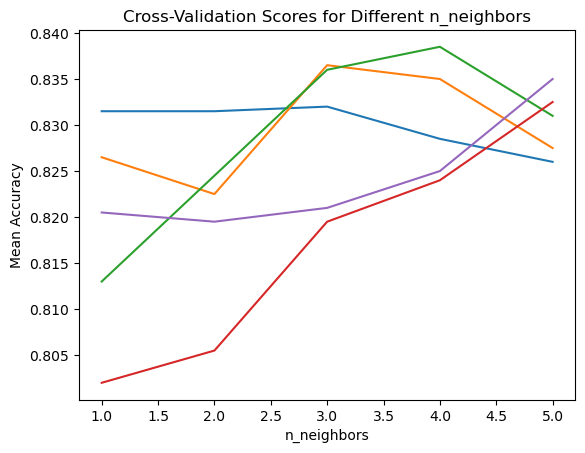

In [61]:
n_values = [1, 2, 3,4, 5]
cv=5
def cross_val_plot(X_train,y_train,n,cv):
    all_scores = []
    for n in n_values:
        scores = cross_val(X_train, y_train, n, cv)
        all_scores.append(scores)
        # Plotting
    plt.plot(n_values, all_scores, marker='none')
    plt.title('Cross-Validation Scores for Different n_neighbors')
    plt.xlabel('n_neighbors')
    plt.ylabel('Mean Accuracy')
    plt.show()


cross_val_plot(X_train,y_train, n_values, cv)

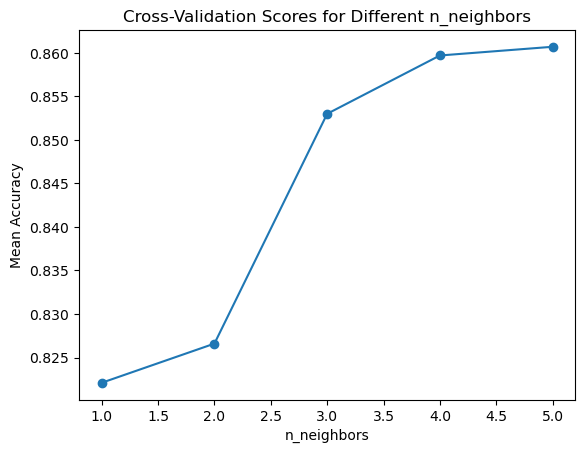

In [43]:
def cross_val(X_train, y_train, n, cv):
    classifier = KNeighborsClassifier(n_neighbors=n)
    scores = cross_val_score(classifier, X_train, y_train, cv=cv)
    return np.mean(scores)  # Return the mean score

def cross_val_plot(X_train, y_train, n_values, cv):
    all_scores = [cross_val(X_train, y_train, n, cv) for n in n_values]

    # Plotting
    plt.plot(n_values, all_scores, marker='o')
    plt.title('Cross-Validation Scores for Different n_neighbors')
    plt.xlabel('n_neighbors')
    plt.ylabel('Mean Accuracy')
    plt.show()

# Assuming X_train and y_train are your feature matrix and target vector
# Also, assuming n_values is a list of hyperparameter values to be tested
#cross_val_plot(X_train, y_train, n_values, cv=5)
cross_val_plot(lda_transformed_X_train,y_train,n_values,cv)


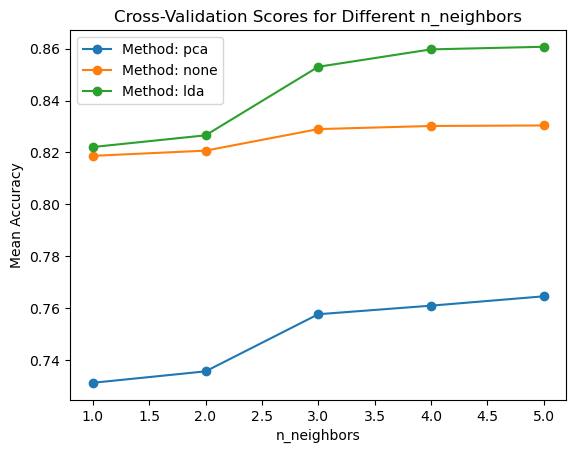

In [62]:


def cross_val(X_train, y_train, n, cv):
    classifier = KNeighborsClassifier(n_neighbors=n)
    scores = cross_val_score(classifier, X_train, y_train, cv=cv)
    return np.mean(scores)  # Return the mean score

def cross_val_plot(data_sets, n_values, cv):
    Methods = ['pca', 'none', 'lda']
    for i, (X_train, y_train) in enumerate(data_sets):
        method_name = Methods[i]
        all_scores = [cross_val(X_train, y_train, n, cv) for n in n_values]
        plt.plot(n_values, all_scores, marker='o', label=f'Method: {method_name}')

    # Plotting
    plt.title('Cross-Validation Scores for Different n_neighbors')
    plt.xlabel('n_neighbors')
    plt.ylabel('Mean Accuracy')
    plt.legend()
    plt.show()

# Assuming pca_transformed_X_train, y_train, and another set of X_train, y_train are your datasets
data_sets = [(pca_transformed_X_train, y_train), (X_train, y_train), (lda_transformed_X_train, y_train)]

# Also, assuming n_values is a list of hyperparameter values to be tested
cross_val_plot(data_sets, n_values, cv=5)
